In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

# Data
## Conclusions:
#### 1. Training dataset contains 891 rows and 12 columns.
1. PassengerId - unique for each passenger.
2. Survived - States if passenger survived. 0 - No, 1 - Yes.
3. Pclass - Ticket class. 1 = 1-st class, 2 = 2-nd class, 3 = 3-rd class.
4. Name - Always in format 'Surname, title. Name'. Title can be extracted from this column and used in further analysis.
5. Sex - One of: 'men', 'female'.
6. Age - Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5. **Has 177 missing values.**
7. SibSp - Number of family members aboard Titanic being one of: brother, sister, stepbrother, stepsister, husband, wife.
8. Parch - Number of family members aboard Titanic being one of: mother, father, children.
9. Ticket - Ticket number.
10. Fare - Passenger fare. Numerical.
11. Cabin - Always starts with a letter. At this point I decided to extract only this letter, and therefore changing this column to grouped categorical variable. **Has 687 missing values**, which will be investigated in later part analysis.
12. Embarked - Port of Embarkation. 3 Categories. C = Cherbourg, Q = Queenstown, S = Southampton. **Has 2 missing values**.

#### 2. Test dataset contains 418 rows and 11 columns (it doesn't have survived column).
1. It has **86 missing values in Age** column, **327 missing values in Cabin** column, and **1 missing value in Fare** column.

In [2]:
#Importing data
#train.csv contains dataset with column Survived. 
#test.csv is dataset without column Survived where we want to predict if person survived based on other informations.
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

### Inspecting available data

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Number of unique values in each column

In [8]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### Extracting only first letter from Cabin

In [9]:
train['Cabin'] = train['Cabin'].map(lambda x: x if pd.isna(x) else x[0])
test['Cabin'] = test['Cabin'].map(lambda x: x if pd.isna(x) else x[0])

### Extracting Title from Name

In [10]:
train['Title'] = train['Name'].str.extract(r"([A-Z][a-z]+)\.")
test['Title'] = test['Name'].str.extract(r"([A-Z][a-z]+)\.")
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

#### Grouping titles with less than 5 observations in train dataset in category 'Other'

In [11]:
other = [title for title in train["Title"].unique() if train["Title"].value_counts()[title]<5] #Finding titles with less than 6 observations
train['Title'] = train['Title'].map(lambda x: 'Other' if x in other else x)
test['Title'] = test['Title'].map(lambda x: 'Other' if x in other else x)
test.loc[test['Title'] == 'Dona','Title'] = 'Other'
train['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: Title, dtype: int64

In [12]:
# Creating lists for categorical and numerical features for later analysis
categorical_features = ["Title","Pclass","Sex","SibSp","Parch","Embarked"]
numeric_features = ['Age',"Fare"]

# Missing values
## Conclusions
1. Cabin has a lot of missing values that cannot be easily imputed based on any other columns, however it provide usefull information about target variable. I replaced missing values with value 'U', standing for 'Unknown'.
2. Frstly missing age can be imputed based on mean in Title group for 'Master', 'Miss' and 'Mrs', because masters are mainly children, misses are mainly young women, and Mrs are mainly middle age women.
3. Then records that are still missing will be imputed by mean in Pclass groups, because first and second class passengers tend to be older than third class passengers.
4. Two missing values in Embarked may be replaced with  most frequent value in this column (Southampton).
5. One missing value in Fare column in test dataset can be imputed with 3rd class fare median.

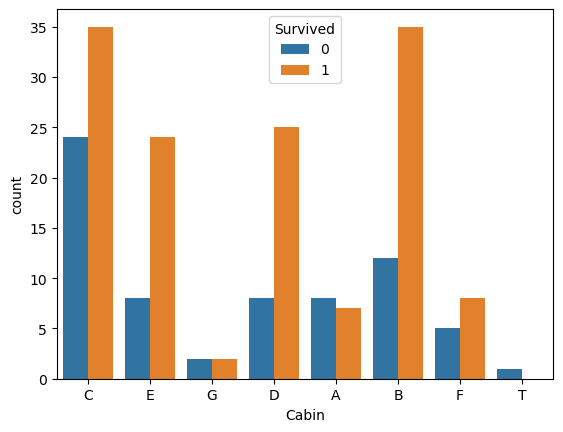

In [13]:
_ = sns.countplot(data=train, x='Cabin', hue='Survived')

#### Filling missing values in Cabin column

In [14]:
train['Cabin'].fillna('U', inplace = True)
test['Cabin'].fillna('U', inplace = True)

#### Investigating Age distribution in each categorical variable

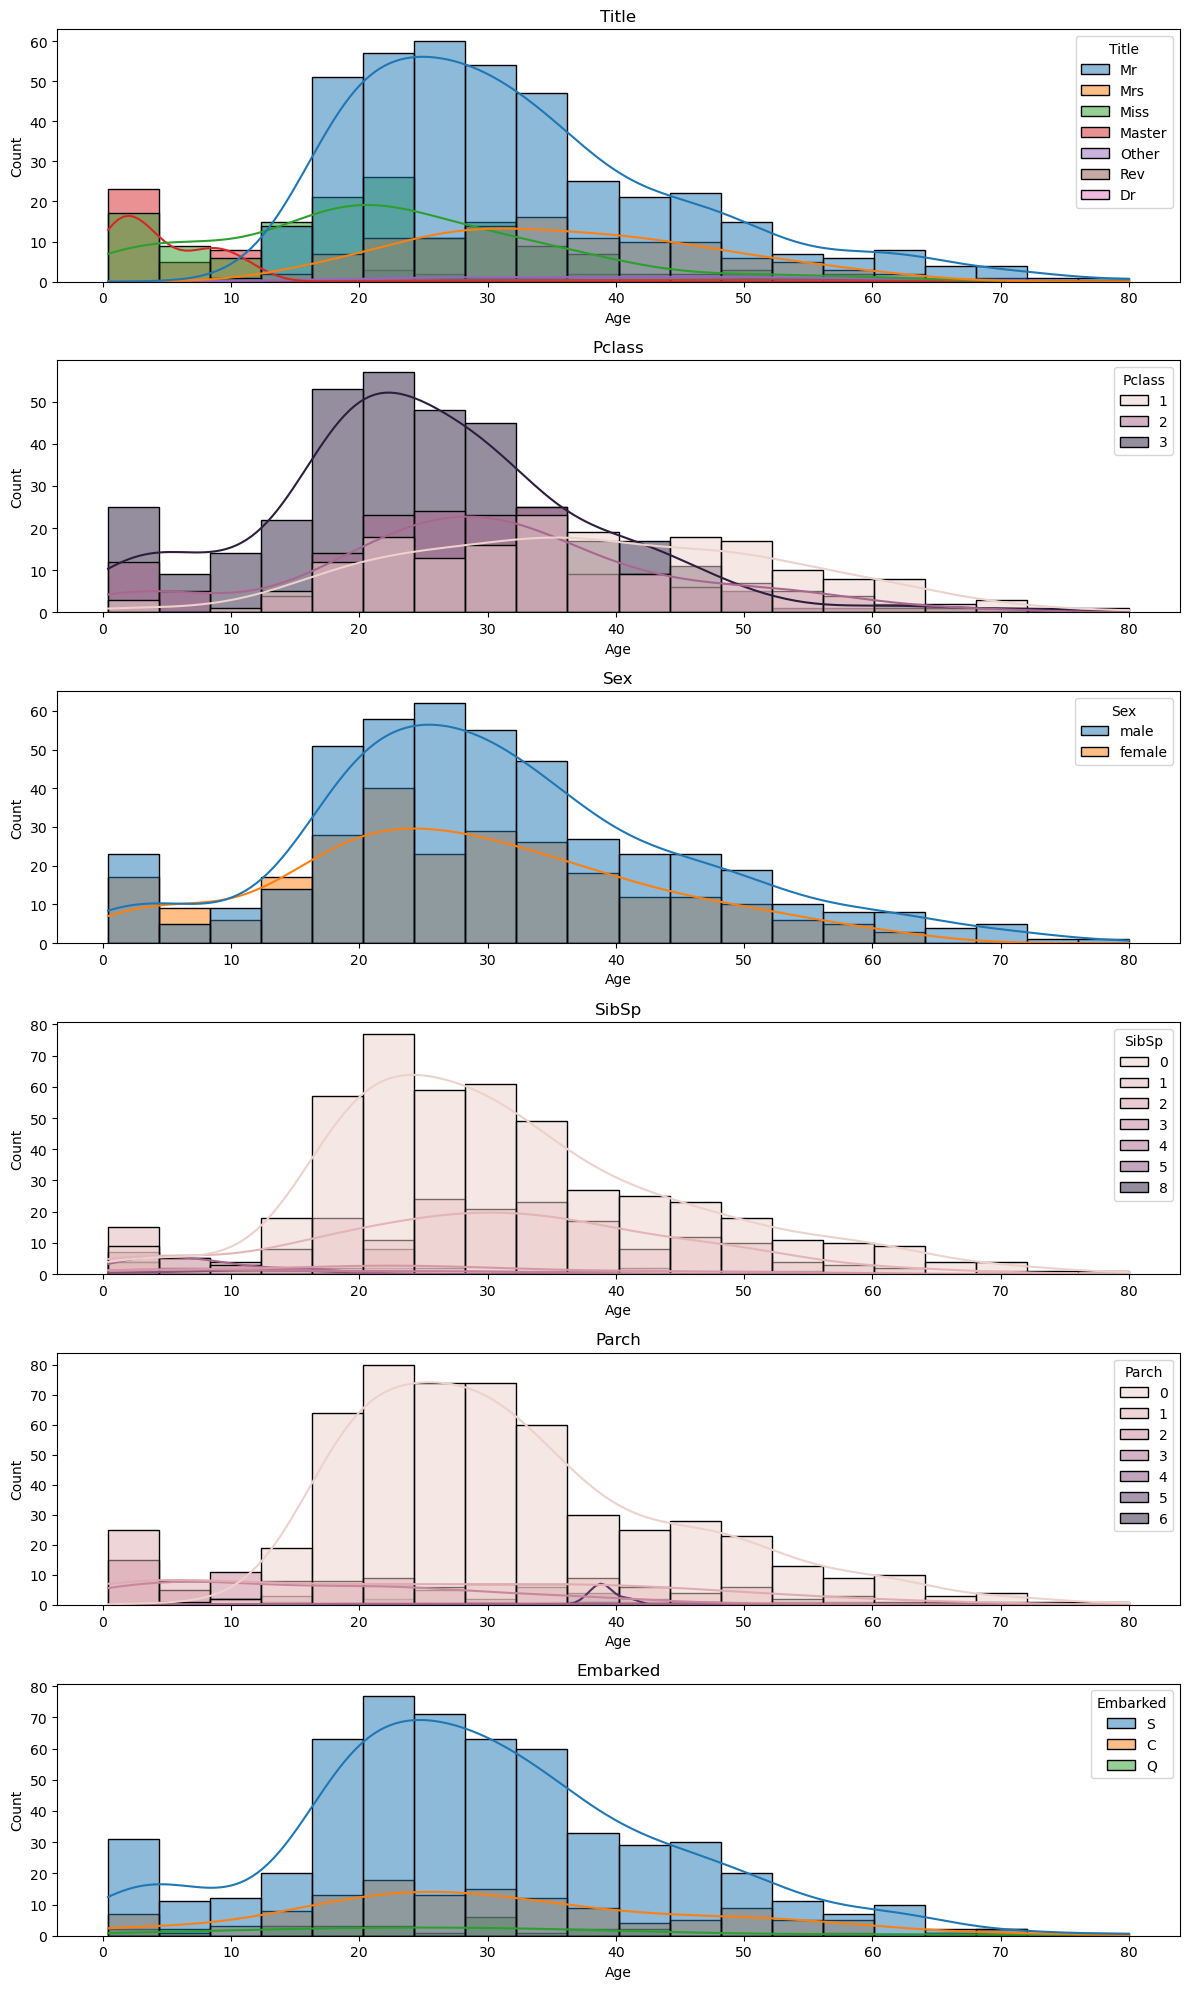

In [15]:
fig=plt.figure(figsize=(12,20))
for index, column in enumerate(categorical_features):
    ax=fig.add_subplot(6,1,index+1)
    sns.histplot(data=train, x="Age", axes=ax,kde = True, hue=column)
    ax.set_title(column)
fig.tight_layout()
plt.show()

#### Imputing Age missing values

In [16]:
##Imputing in training set
print(f"Missing values in training set before processing: {train.Age.isna().sum()}")
train.loc[((train['Age'].isna()) & (train['Title'] == 'Master')),'Age'] = train[train['Title'] == 'Master']['Age'].mean()
train.loc[((train['Age'].isna()) & (train['Title'] == 'Miss')),'Age'] = train[train['Title'] == 'Miss']['Age'].mean()
train.loc[((train['Age'].isna()) & (train['Title'] == 'Mrs')),'Age'] = train[train['Title'] == 'Mrs']['Age'].mean()
train.loc[((train['Age'].isna()) & (train['Pclass'] == 1)),'Age']= train[train['Pclass'] == 1]['Age'].mean()
train.loc[((train['Age'].isna()) & (train['Pclass'] == 2)),'Age']= train[train['Pclass'] == 2]['Age'].mean()
train.loc[((train['Age'].isna()) & (train['Pclass'] == 3)),'Age'] = train[train['Pclass'] == 3]['Age'].mean()
print(f"Missing values in training set after processing: {train.Age.isna().sum()}")
##Imputing in test set
print(f"Missing values in test set before processing: {test.Age.isna().sum()}")
test.loc[((test['Age'].isna()) & (test['Title'] == 'Master')),'Age'] = train[train['Title'] == 'Master']['Age'].mean()
test.loc[((test['Age'].isna()) & (test['Title'] == 'Miss')),'Age'] = train[train['Title'] == 'Miss']['Age'].mean()
test.loc[((test['Age'].isna()) & (test['Title'] == 'Mrs')),'Age'] = train[train['Title'] == 'Mrs']['Age'].mean()
test.loc[((test['Age'].isna()) & (test['Pclass'] == 1)),'Age']= train[train['Pclass'] == 1]['Age'].mean()
test.loc[((test['Age'].isna()) & (test['Pclass'] == 2)),'Age']= train[train['Pclass'] == 2]['Age'].mean()
test.loc[((test['Age'].isna()) & (test['Pclass'] == 3)),'Age'] = train[train['Pclass'] == 3]['Age'].mean()
print(f"Missing values in test set after processing: {test.Age.isna().sum()}")


Missing values in training set before processing: 177
Missing values in training set after processing: 0
Missing values in test set before processing: 86
Missing values in test set after processing: 0


#### Imputing Embarked missing values in train set

In [17]:
print(f'Embarked in Southampton represent {round(100*train.Embarked.value_counts().S/len(train),2)}% of all passengers')

Embarked in Southampton represent 72.28% of all passengers


In [18]:
print(f"Missing values in training set before processing: {train.Embarked.isna().sum()}")
train['Embarked'].fillna('S', inplace = True)
print(f"Missing values in training set after processing: {train.Embarked.isna().sum()}")

Missing values in training set before processing: 2
Missing values in training set after processing: 0


#### Imputing Fare missing values in test set

In [19]:
#Only missing Fare value is from person in third class. Thats why I imputed this value by 3rd class median.
print(f"Missing values in test set before processing: {test.Fare.isna().sum()}")
test.loc[pd.isna(test['Fare']),'Fare'] = test[test['Pclass'] == 3]['Fare'].median()
print(f"Missing values in test set after processing: {train.Fare.isna().sum()}")

Missing values in test set before processing: 1
Missing values in test set after processing: 0


### Datasets after dealing with missing values

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


# Exploratory data analysis
## Conclusions
1. There is a mild imbalancement in target variable.
2. Title, Pclass and Sex are categorical variables with biggest dependency with survival rate.
3. Embarked in Cherbourg were more likely to survive.
4. Numerical variables Age and Fare can be good indicators for predicting target variable.
5. SibSp and Parch columns show similar distribution within Survival category. They may be combined in one column showing Family size.

In [22]:
print(f"Percent of survivors:  {round(100*train.Survived.sum()/len(train.Survived),2)}%")
print(f"Percent of killed: {round(100*(len(train.Survived)-train.Survived.sum())/len(train.Survived),2)}%")

Percent of survivors:  38.38%
Percent of killed: 61.62%


### Plotting Survival distribution

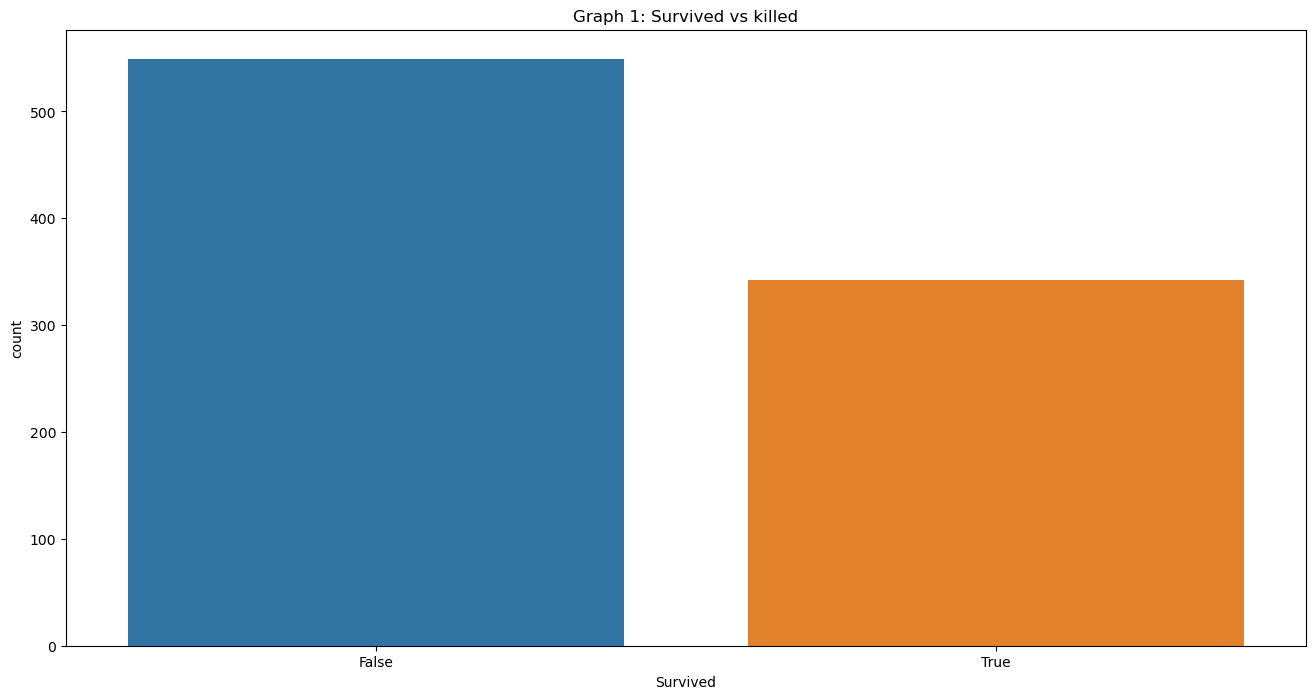

In [23]:
fig = plt.figure(figsize = (16,8))
_ = sns.countplot(data = train, x = 'Survived')
_ = plt.title('Graph 1: Survived vs killed')
_ = plt.xlabel('Survived')
_ = plt.xticks(ticks = [0,1], labels = ['False','True'])

## Ploting categorical features distributions within survived category

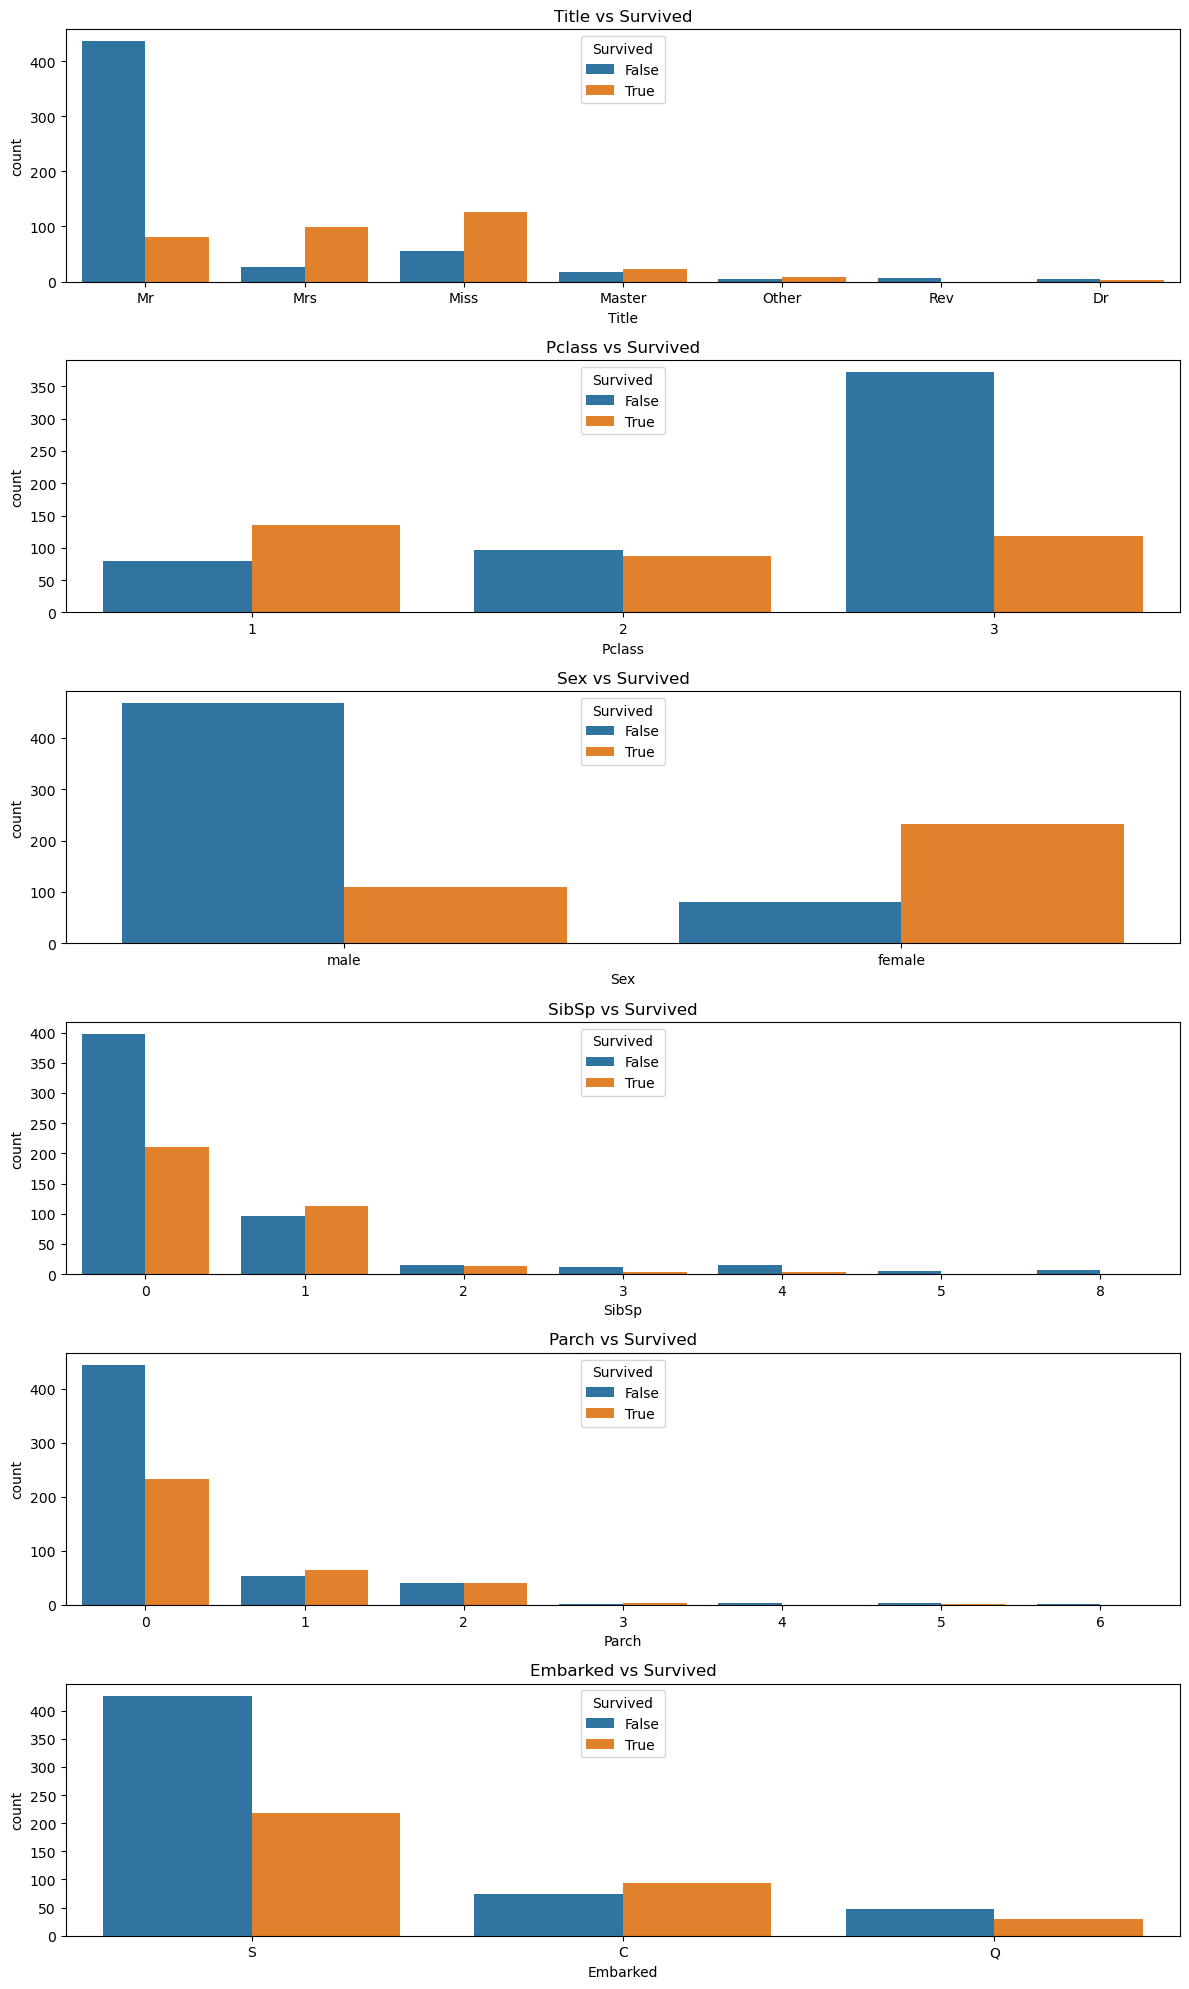

In [24]:
fig=plt.figure(figsize=(12,20))
for index, column in enumerate(categorical_features):
    ax=fig.add_subplot(6,1,index+1)
    sns.countplot(data=train, x=column, axes=ax, hue='Survived')
    ax.set_title(f'{column} vs Survived')
    ax.legend(title='Survived', loc='upper center', labels=['False', 'True'])
fig.tight_layout()
plt.show()

## Ploting numerical features distributions within survived category

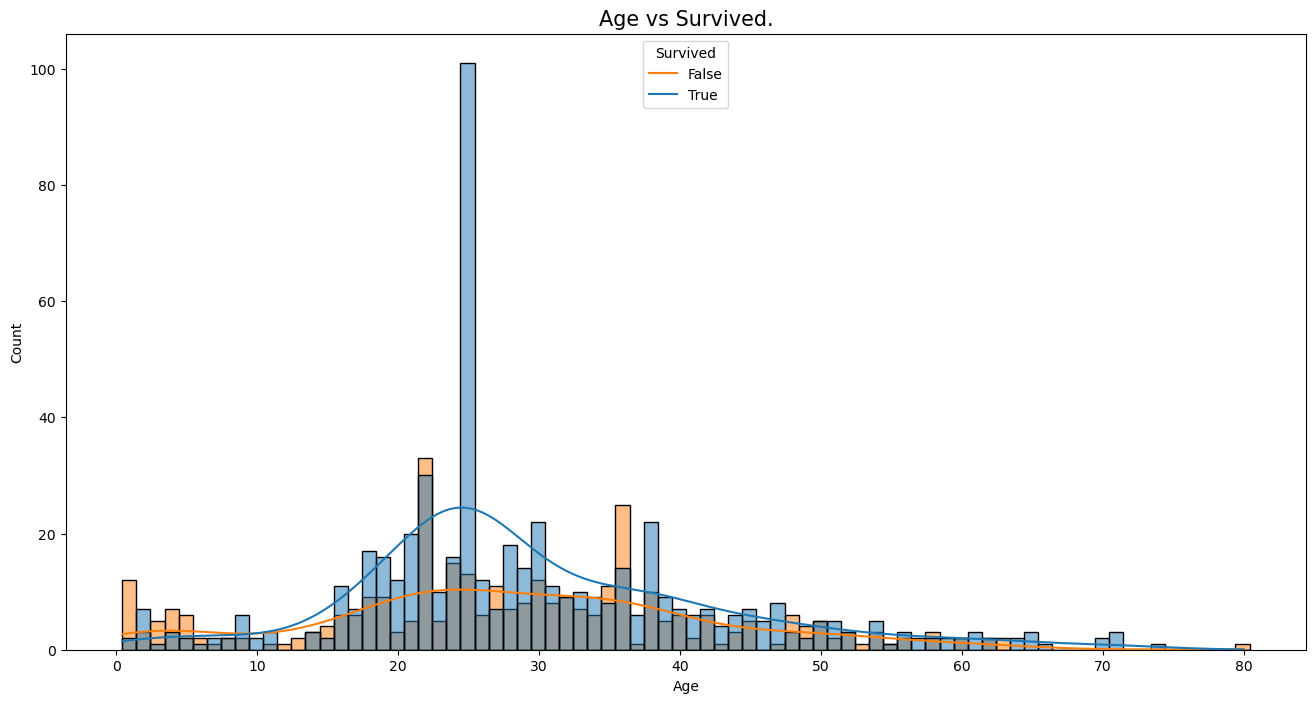

In [25]:
fig = plt.figure(figsize = (16,8))
_ = sns.histplot(data=train, x="Age", binwidth=1,kde = True, hue='Survived')
_ = plt.title("Age vs Survived.", size = 15)
_ = plt.legend(title='Survived', loc='upper center', labels=['False', 'True'])

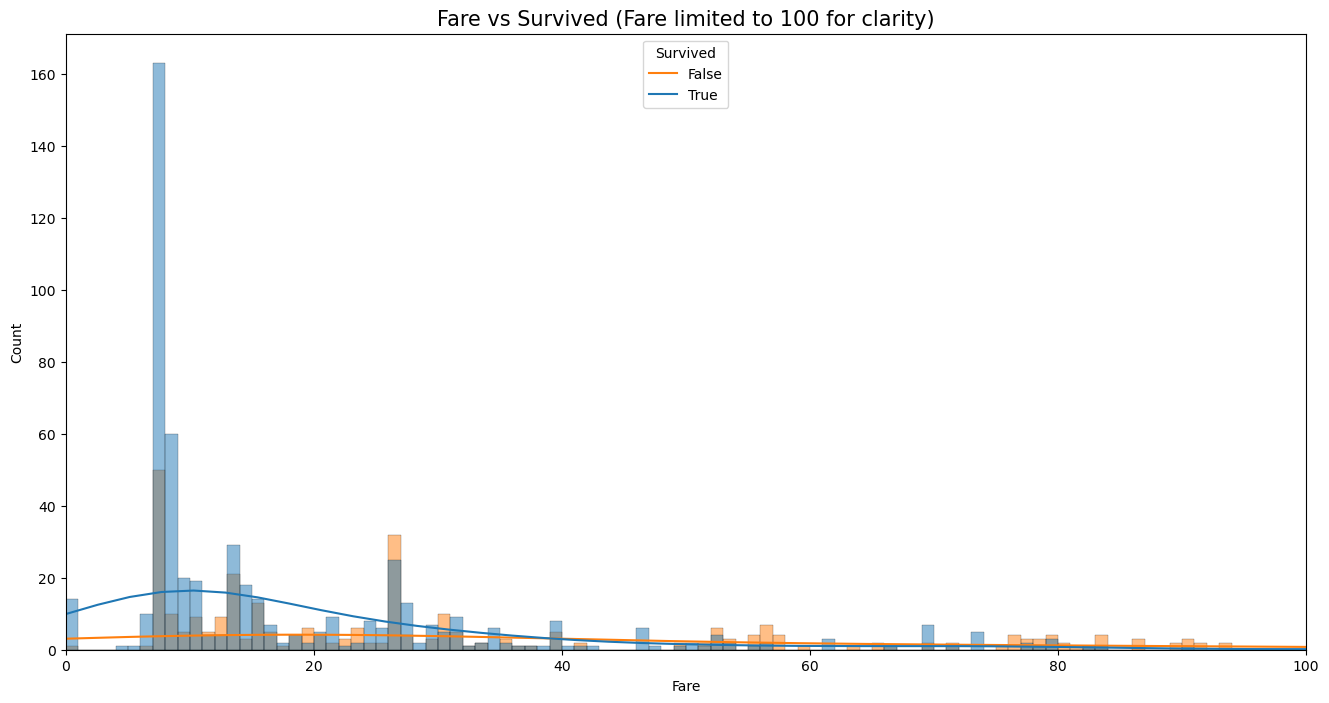

In [26]:
fig = plt.figure(figsize = (16,8))
_ = sns.histplot(data=train, x="Fare", binwidth=1,kde = True, hue='Survived')
_ = plt.xlim(0,100)
_ = plt.title("Fare vs Survived (Fare limited to 100 for clarity)", size = 15)
_ = plt.legend(title='Survived', loc='upper center', labels=['False', 'True'])

### Creating Family Size column and investigating it's distribution within survival category.

In [27]:
train['FamilySize'] = train['SibSp']+train['Parch']
test['FamilySize'] = test['SibSp']+test['Parch']

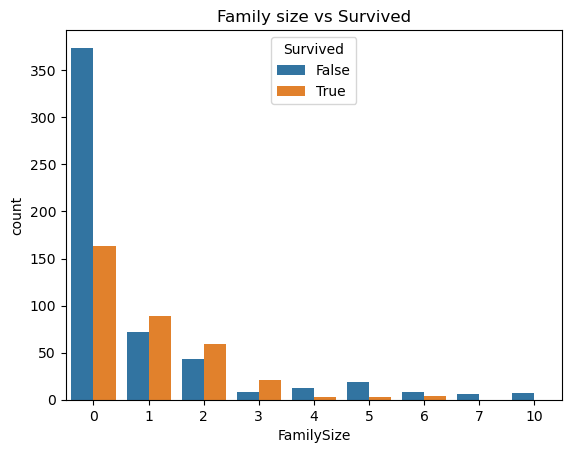

In [28]:
_ = sns.countplot(data = train, x = 'FamilySize', hue = 'Survived')
_ = plt.title('Family size vs Survived')
_ = plt.legend(title='Survived', loc='upper center', labels=['False', 'True'])

# Preprocessing

### Droping PassengerId, Name and Ticket from train and test datasets.

In [29]:
X_train = train.drop(labels = ['PassengerId','Name','Ticket'], axis = 'columns')
X_test = test.drop(labels = ['PassengerId','Name','Ticket'], axis = 'columns')

In [30]:
X_train = X_train.drop('Survived', axis = 'columns')
y_train = train['Survived']

### Scaling numerical variables and performing log transformation on Fare.

In [31]:
scaler = StandardScaler()
X_train.loc[:,"Age"] = scaler.fit_transform(X_train["Age"].to_numpy().reshape(-1, 1))
X_test.loc[:,"Age"] = scaler.transform(test["Age"].to_numpy().reshape(-1, 1))
X_train['Fare'] = np.log(X_train['Fare']+1)
X_test["Fare"] = np.log(X_test['Fare']+1)

In [32]:
scaler = StandardScaler()
X_train.loc[:,"Fare"] = scaler.fit_transform(X_train["Fare"].to_numpy().reshape(-1, 1))
X_test.loc[:,"Fare"] = scaler.transform(test["Fare"].to_numpy().reshape(-1, 1))

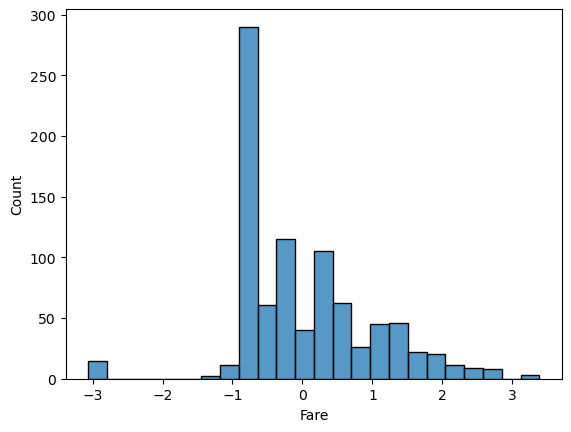

In [33]:
_ = sns.histplot(X_train['Fare'])

### Preprocessing

In [34]:
features_to_one_hot_encode = ['Sex','Cabin','Embarked','Title']

### One hot encoding chosen categorical variables

In [35]:
X_train = pd.get_dummies(X_train, columns = features_to_one_hot_encode)
X_test = pd.get_dummies(X_test, columns = features_to_one_hot_encode)
X_test.insert(16, 'Cabin_T',0)

# Choosing best features
Since this dataset is small I decided to use sequential feature selector for choosing best features.

#### Choosing best features with SequentialFeatureSelector.
Cell is commented, because feature selector takes long time to run. Best features returned by selector are saved in features list in next cell.

In [36]:
#model = CatBoostClassifier(verbose = False,allow_const_label = True)

#sfs = SequentialFeatureSelector(model,scoring = 'accuracy')

#sfs.fit(X_train, y_train)
#features = list(sfs.get_feature_names_out())

In [37]:
features = ['Pclass','Age','Parch','Fare','FamilySize','Sex_female','Cabin_B','Cabin_E','Cabin_F','Cabin_T', 'Embarked_Q', 'Title_Dr', 'Title_Rev']

In [38]:
X_train = X_train[features]
X_test = X_test[features]

# Choosing best model

#### In catboost documentation there is suggestion to set higher border count for features being strongest indicators for prediction.
Cell below show index of feature I find the best indicator, needed to specify it's border_count in model.

In [39]:
list(X_train.columns).index('Sex_female')

5

#### Grid searching model hyperparameters
Cell is commented, because grid search takes long time to run. Best parameters returned by search are used in final model.

In [40]:
# param_grid = {'learning_rate': [0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.1],
#              'depth':[4,5,6,7,8,9,10],
#              'iterations' : [500, 1000, 2000, 3000],
#              }
# model = CatBoostClassifier(verbose = False,border_count = 254,per_float_feature_quantization = ['5:border_count=1024'])
# clf = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, n_jobs = -1)
# clf.fit(X_train,y_train)

# print(f'Best accuracy: {clf.best_score_}')
# print(f'Best parameters: {clf.best_params_}')

Learning rate in final model was lowered relative to best parameters found in grid search to reduce overfitting.

In [41]:
final_model = CatBoostClassifier(verbose = False,border_count = 254,per_float_feature_quantization = ['5:border_count=1024'], depth = 5, iterations = 3000, learning_rate = 0.0001)

In [42]:
final_model.fit(X_train,y_train)

In [43]:
predictions = final_model.predict(X_test)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
print(output)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


#### Checking if distribution of survival in prediction is similar to distribution of survival in training set

In [44]:
output.Survived.sum()/len(test)*100

34.44976076555024

## This prediction was validated on kaggle Titanic competition and had 78,5% accuracy.